<a href="https://colab.research.google.com/github/xoxominji/22-1-ESAA-Practice/blob/main/0620_session_%EB%B0%95%EB%AF%BC%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DACON [필사] 
## [Baseline] 1. TensorFlow를 활용한 이미지 분류

### **Convolutional Neural Network(CNN)**

#### **Neural Network(인공신경망)**
: 여러 입력값을 받아 일정 수준을 넘어서게 되면 활성화되고 출력값을 내보냄
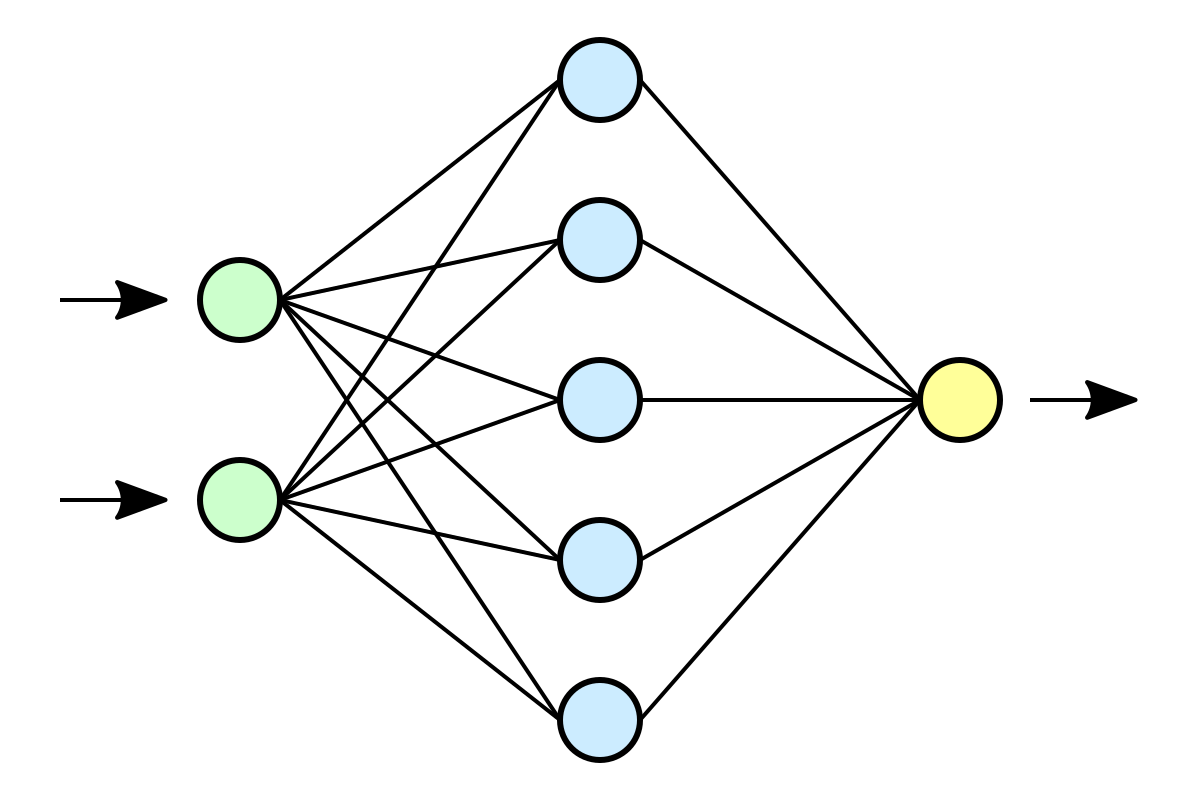

#### **Sigmoid(시그모이드 함수)**
: 활성화 함수(Activation function)

0.5 미만은 0, 이상은 1 출력

$sigmoid(x)=\frac{1}{1+e^-x}$

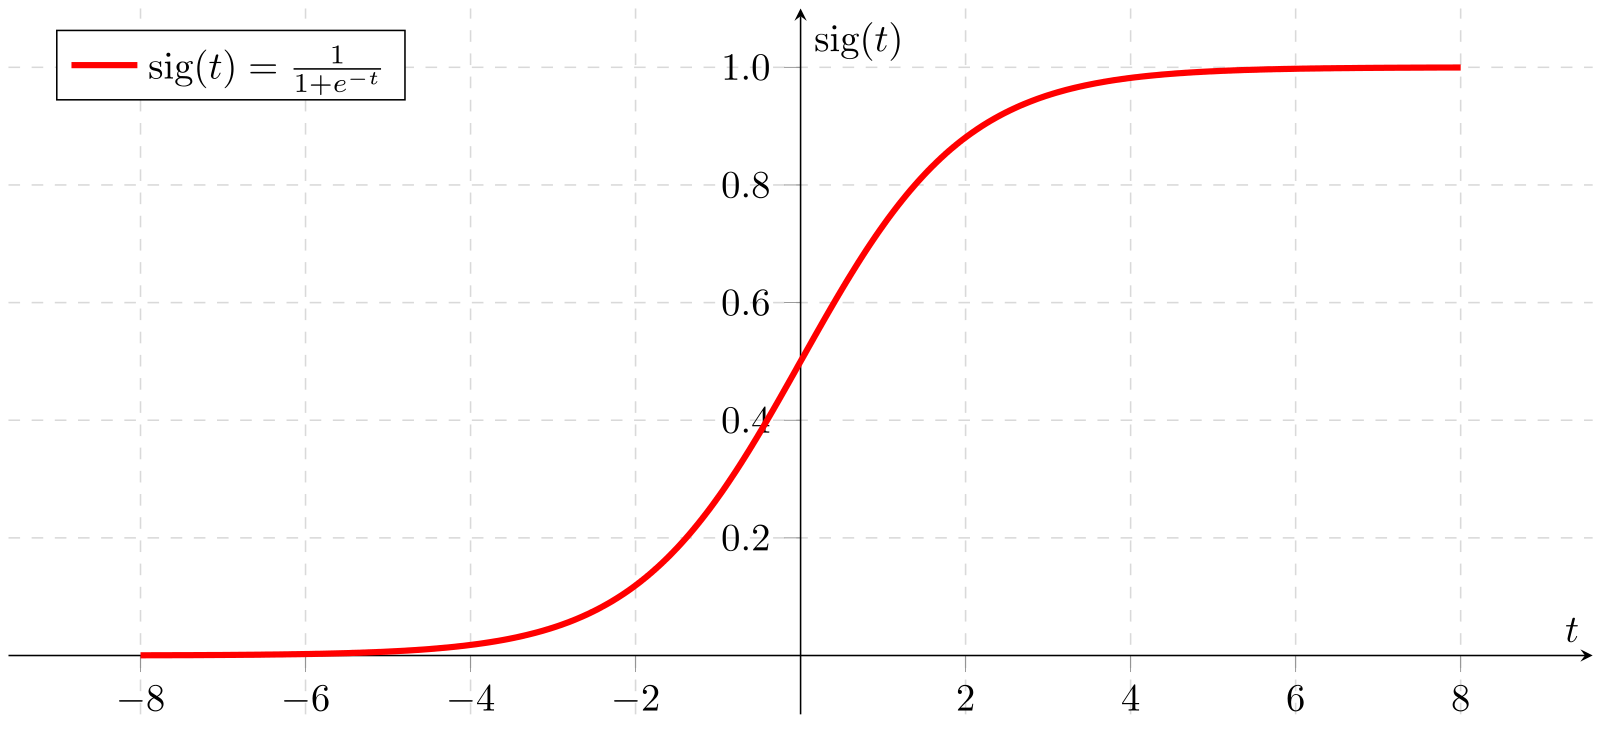

sigmoid 함수의 단점:

그래프를 보시면 양 극단 값의 기울기(미분값)이 0에 가까워져 학습이 되지 않는 문제가 발생함. 이를 Gradient Vanishing 문제라고 하는데 이러한 문제를 해결하기 위해 다양한 활성화 함수들이 고안됨

#### **ReLU 함수**

: Gradient Vanishing 문제를 해결하는 활성화 함수

`relu(x) = 0 if x < 0 else max(0,x)`

위 식과 같이 ReLU 함수는 입력값을 0과 비교해 둘 중 큰 값을 출력합니다.

장점: 계산이 빠르고 양 극단값이 포화되지 않는다

단점: 여전히 음수인 경우에는 0을 출력하여 학습이 이루어지지 않는다

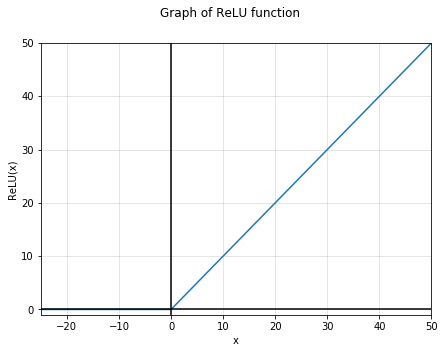

#### **Perceptron(퍼셉트론)**

신경망의 기원이 되는 개념으로, Frank Rosenblatt이 1957년 고안한 알고리즘

이는 여러 신호를 입력받아 0(흐르지 않는다) 또는 1(흐른다)이라는 출력값을 앞으로 전달

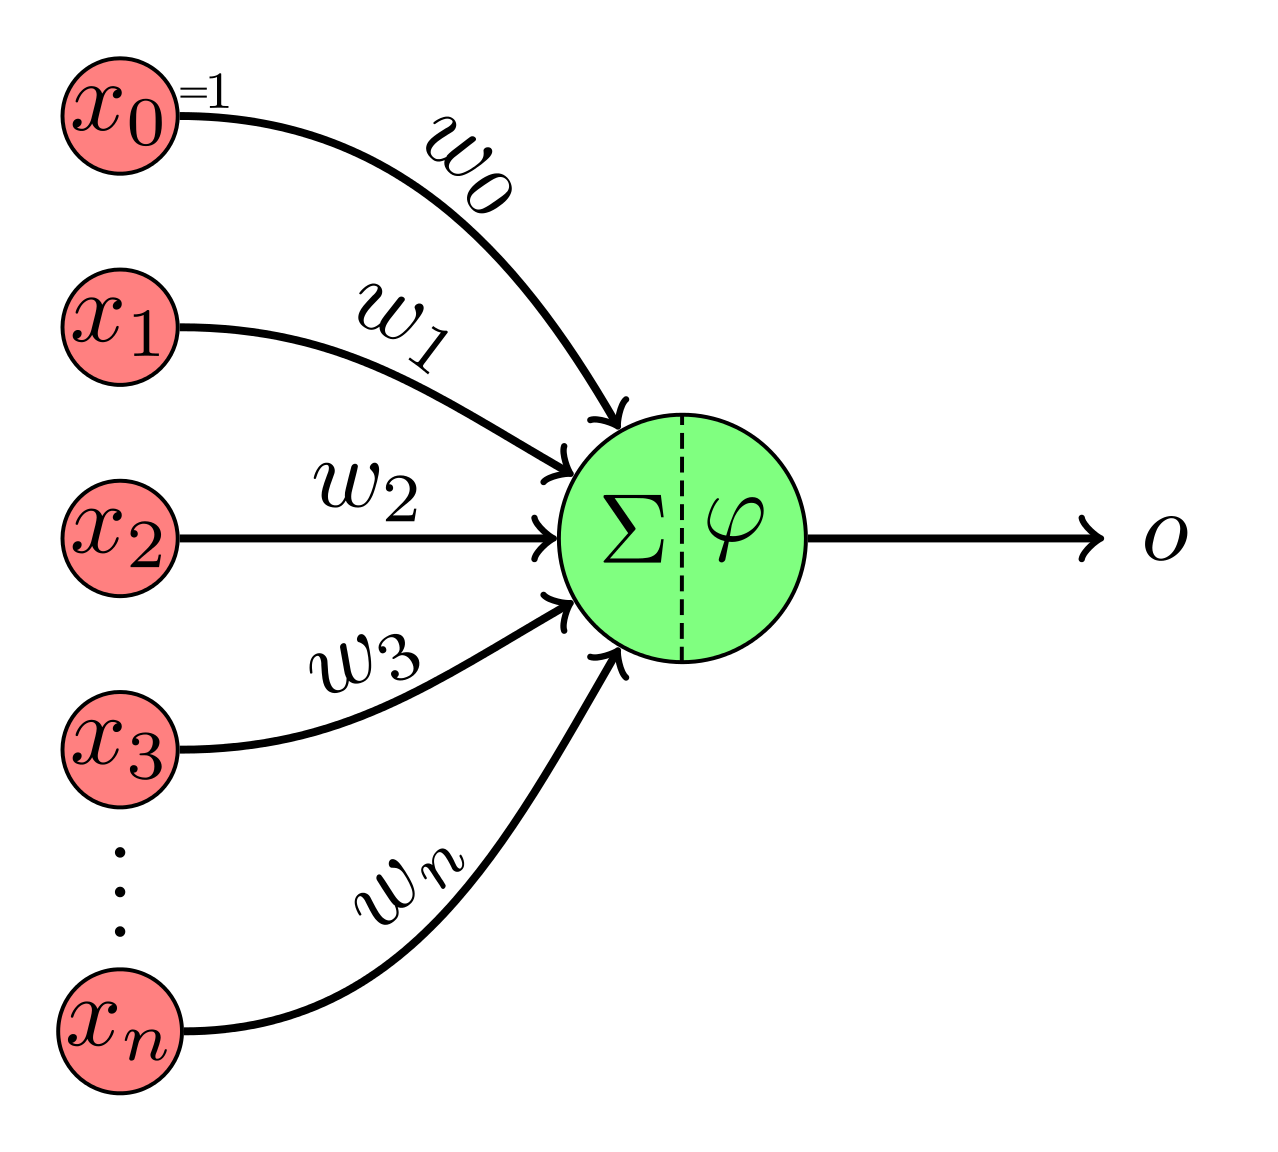

각 입력 신호 X는 각 가중치 w와 곱해짐. 가중치가 클수록 그 신호가 중요하다는 뜻

그러나 퍼셉트론은 단순한 선형 분류기로, AND나 OR과 같은 분류는 가능하나 XOR 분류는 불가능

#### **MLP(Multi-Layer Perceptron)**

다층 퍼셉트론: 직선형 영역만 표시할 수 있는 단층 퍼셉트론의 한계를 극복하기 위해 고안된 것

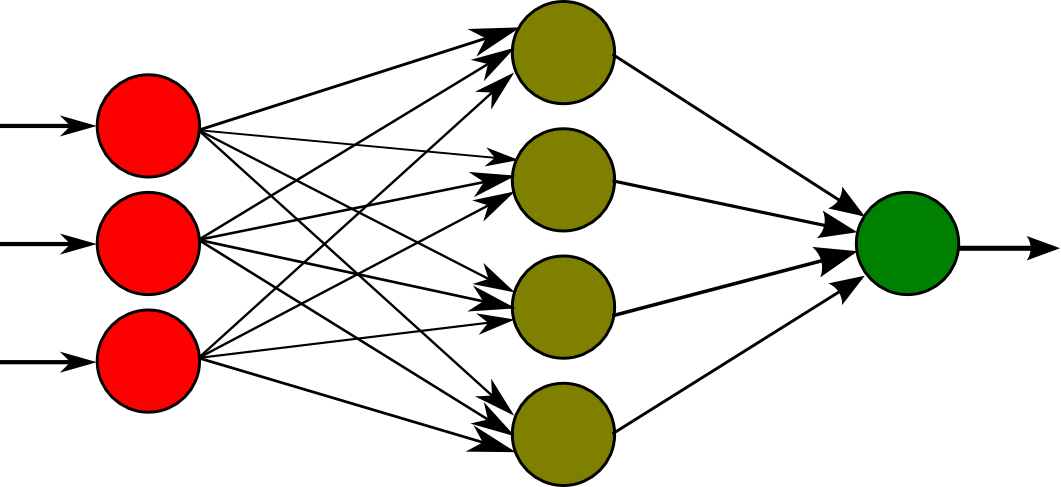

다층 퍼셉트론은  비선형 영역까지 표현 가능함

=> 각 영역을 직선으로 분리가 불가능한 XOR 게이트 구현 가능

### 환경 설정 및 데이터 로드

In [1]:
import os
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

In [2]:
import tensorflow as tf

(training_images, training_labels), (test_images,test_idx) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 6s 0us/step


In [ ]:
#create training dataset
from glob import glob
import numpy as np
import PIL
from PIL import Image

path = './data/train/'

training_images = []
training_labels = []

for filename in glob(path +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img) #read img
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images 
        label = filename.split('/')[3] #get label
        training_labels.append(label) #append label
        
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

In [ ]:
#create test dataset

path = './data/test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename) #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    
    label = filename.split('/')[3] #get id 
    test_idx.append(label) #append id
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

불러온 데이터셋 살펴보기

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(training_images[i])
    print(training_labels[i], end=",")
plt.show()

10가지 종류(0~9까지의 라벨)의 이미지

CIFAR-10 이미지 데이터셋을 분류하기 위해 CNN의 기본 개념을 이해하고 데이터셋에 적용해

목표: CNN 모델을 통해 10가지 종류의 이미지들을 각 레이블에 맞게 분류하기

### **데이터셋 준비**

데이터셋을 X와 y로 분리하고, 

train 이미지 데이터셋을 학습용과 검증용으로 나누기

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.2, random_state=42)

X_test = test_images

In [4]:
print('X_train 크기:',X_train.shape)
print('X_valid 크기:',X_valid.shape)
print('X_test  크기:',X_test.shape)

X_train 크기: (40000, 32, 32, 3)
X_valid 크기: (10000, 32, 32, 3)
X_test  크기: (10000, 32, 32, 3)


이미지의 RGB 채널은 각각 0~255까지의 값을 갖고 있기 때문에

255로 나누어 0에서 1 사이 값을 갖도록 normalization을 해줍니다.

In [5]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

### CNN 모델 설계

필요한 layer들을 추가하며 CNN 모델을 설계


In [6]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    tf.keras.layers.Dropout(0.23), # 무작위로 퍼셉트론 비활성화(23%)
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='SAME'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'),
    tf.keras.layers.Dropout(0.23),
    tf.keras.layers.Flatten(), # N차원 배열 -> 1차원 배열
    tf.keras.layers.Dense(1024, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

이제 위 모델에 사용한 Layer들

#### **Convolution Layer**

: 이미지의 특징(feature map)을 추출해내는 역할

입력 데이터가 주어지면 필터를 이용해 특징을 추출한 다음 아웃풋을 내보냄

이 필터는 커널(Kernel) 혹은 가중치의 배열이라고도 부르며 이 값을 조정하는 것이 곧 학습을 의미

첫번째 Convolution Layer에서는 3x3 크기의 커널을 사용했음. 이는 곧 학습해야 할 가중치가 9개라는 뜻임

- **Stride**

: 커널을 이동시키는 거리, 특별한 언급이 없다면 1로 가정(default)



[참고](https://hdevstudy.tistory.com/116)

- **Padding**

Convolution은 입력 데이터의 크기 축소함. 

이를 위해 주변에 값이 0인 셀들을 추가(Padding)해서 입력 데이터의 크기를 유지 (zero padding)


필터로 인해 특징이 추출되면 자연스럽게 크기가 작아지는데, 이미지 벡터들 가장자리에 0을 채워 Convolution Layer를 통과할 때 크기를 동일하게 유지함

<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Convolution_arithmetic_-_Padding_strides_odd.gif" />

#### **Pooling Layer - Max Pooling(최대풀링)**

: 데이터의 공간적 크기를 축소

보통 이 레이어에서 이미지의 크기를 조절

CNN에서는 주로 Max-Pooling 방식을 사용

Conv layer는 이미지의 특정 영역의 특징을 잡아내는 역할이라면, Pooling 은 이미지의 크기를 줄이는 동시에 이미지의 전체의 특징 또한 *보존*

따라서 Pooling 은 모델로 하여금 이미지 전체를 볼 수 있게 도와줍니다.

Max Pooling에서는 선택된 영역에서 가장 큰 값을 뽑아 대표값으로 설정

이를 통해 학습 시간을 단축하고 오버피팅 문제 완화 가능

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png?20151216202132" />


#### **Dropout**

: 신경망의 유닛(뉴런)들을 랜덤으로 비활성화 하여 과적합(Overfittng)을 방지하기 위한 기법

#### **Fully Connected Layer(완전연결층)**

-  **Flatten Layer**

N차원 배열을 1차원으로 변환

- **Dense Layer **

1차원 배열을 뉴럴넷에 입력

이때, Dense Layer 는 오로지 퍼셉트론으로 이루어진 layer


- **Softmax 함수**

마지막 layer에서 class 별 확률를 출력하기 위해 사용 

In [7]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

- **Loss Functinon (손실 함수)**

: 실재 값과 모델이 예측한 값의 거리를 출력하는 함수

모델의 예측이 얼마나 틀렸는지를 알려주는 함수

이 때 "모델의 예측이 얼마나 틀렸는지" 를 어떻게 정의하느냐에 따라 어떤 Loss Function 을 사용할 지가 정해짐

이번 베이스라인에서는 최적화 함수로는 Adam 함수를 사용했고, 손실함수로는 'sparse_categorical_crossentropy', 그리고 평가지표로는 정확도를 사용했습니다.

모델을 완성했으면 summary() 함수를 통해 모델의 세부 내용를 요약 출력해봅니다.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)          0

### **학습**

#### **batch size(배치크기)**

: cpu 또는 gpu 연산 시, 하드웨어로 로드되는 데이터의 개수

본인의 컴퓨팅 환경(gpu 메모리 용량)에 따라 batch size 조절


모델 학습 과정에 영향을 끼치므로 하드웨어 상황을 고려하면서도 학습 과정 또한 고려하여 batch size 를 설정해야함

#### **epoch**
: 전체 트레이닝 셋이 신경망을 통과한 횟수

1-epoch는 전체 트레이닝 셋이 하나의 신경망에 적용되어 순전파와 역전파를 통해 신경망을 한 번 통과했다는 뜻

epoch가 많을 수록 학습이 잘되는 것 X

epoch이 너무 적을 경우: 학습이 덜 이루어지는 경우

epoch 이 너무 많을 경우: 과적합 발생

validation loss 와 accuracy으로 epoch을 언제 중단 할지 모니터링


> CNN 모델 설계를 완료했으니 다음과 같이 배치 사이즈와 에폭을 설정하여 모델을 학습

In [9]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=128)

Epoch 1/10
313/313 [==============================] - 48s 150ms/step - loss: 1.7767 - accuracy: 0.3476 - val_loss: 1.5433 - val_accuracy: 0.4413
Epoch 2/10
313/313 [==============================] - 47s 152ms/step - loss: 1.4613 - accuracy: 0.4698 - val_loss: 1.3427 - val_accuracy: 0.5208
Epoch 3/10
313/313 [==============================] - 47s 149ms/step - loss: 1.3465 - accuracy: 0.5137 - val_loss: 1.2203 - val_accuracy: 0.5671
Epoch 4/10
313/313 [==============================] - 47s 149ms/step - loss: 1.2602 - accuracy: 0.5480 - val_loss: 1.1343 - val_accuracy: 0.6012
Epoch 5/10
313/313 [==============================] - 48s 153ms/step - loss: 1.1913 - accuracy: 0.5727 - val_loss: 1.1017 - val_accuracy: 0.6142
Epoch 6/10
313/313 [==============================] - 47s 151ms/step - loss: 1.1439 - accuracy: 0.5918 - val_loss: 1.0093 - val_accuracy: 0.6455
Epoch 7/10
313/313 [==============================] - 47s 150ms/step - loss: 1.0941 - accuracy: 0.6079 - val_loss: 0.9767 - val_ac

## **추론(Prediction)**

In [14]:
import numpy as np
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array([3, 8, 8, 0, 6], dtype=uint8)